<h1 style="font-size: 5em; color: #0000FF; text-shadow: 4px 4px 4px #000000, 0 0 10px #0000FF, 0 0 20px #0000FF; text-align: center; font-weight: bold; text-transform: uppercase;">Electricity Demand Estimation
</h1>

#

# Business Context:
One of leading electricity Distribution Company would like to understand demand for electricity for 
the next 1-2 years to manage the production of electricity and managing the vendors for the same. It 
is one of the important exercises to getting accurate estimation of demand so that they can procure 
or produce the electricity as per the demand

 # Available Data:
The data of monthly electricity consumption available starting from January 1973 to December 2019. 
We need to forecast the demand for next two years.
1. Date – Month & Year
2. Electricity Consumption – Electricity consumption in Trillion Watts

# Business Objective:
## 1.  Need to forecast the demand of electricity for next 1-2 years 
## 2.Calculate error metrics (RMSE, RMSPE, MAPE).
## 3.Compare various models including Decomposition, ETS models, ARIMA/SARIMA Models with various parameters etc….tetc…

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error ,mean_absolute_percentage_error

In [2]:
Electricity=pd.read_csv("D:/A LABS FLODER/ML using python/CASE STUDYS/Demand Estimation/Electricity Consumption.csv")
Electricity

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [3]:
Electricity.shape

(561, 2)

In [4]:
# Converting the Date column into Datetime type  
Electricity['DATE']=pd.to_datetime(Electricity['DATE'])

In [5]:
#Checking the dtypes of the columns in the Electricity df 
Electricity.dtypes

DATE                            datetime64[ns]
Electricty_Consumption_in_TW           float64
dtype: object

In [6]:
# checking  where Electricity df containing NAN are not 
Electricity.isna().sum()

DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

In [7]:
# Checking how many years of data there provided  for  prediction


years=2019-1973
print("There provided " + str(years)+ " years of data for predictions")


There provided 46 years of data for predictions


In [8]:
# Made the Date column as index
Electricity.set_index('DATE',inplace = True)

In [9]:
Electricity

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014


In [10]:
Electricity.shape

(561, 1)

## Checking outliers in the data 

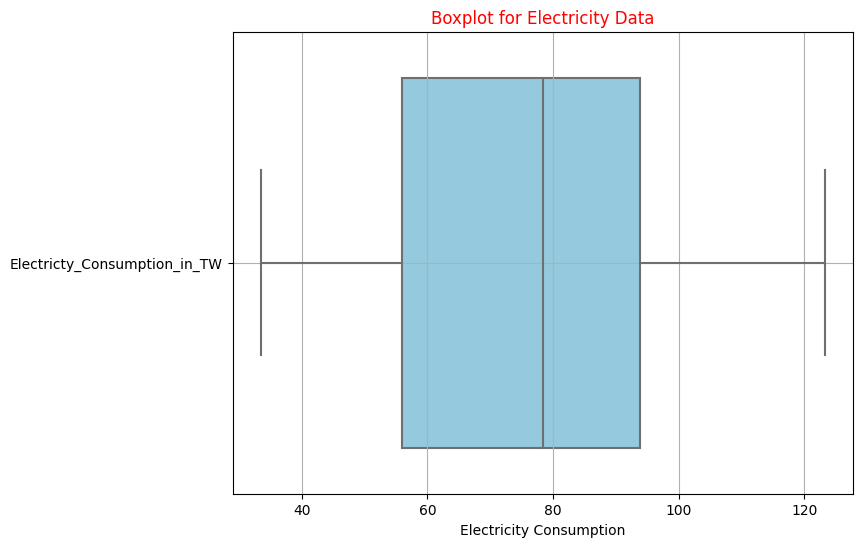

In [11]:
plt.figure(figsize=(8, 6)) 
sns.boxplot(data=Electricity, orient='h', color='skyblue')  
plt.title("Boxplot for Electricity Data", color='red')  
plt.xlabel("Electricity Consumption") 
plt.grid(True)  
plt.show() 

There are no outliers in the data

#

## Checking data is  consistent are not 

### Below you can see why iam doing consistent checking 
### 1.Quality Assurance: Consistency checks help ensure the quality and reliability of the forecasting process. Inconsistent data may indicate errors or anomalies in the data collection or preprocessing stages.
### 2.Model Performance: Inconsistent data can adversely affect the performance of forecasting models. Models trained on inconsistent data may produce unreliable predictions, leading to poor decision-making.
### 3.Identifying Patterns: Consistency checks can help identify patterns or trends in the data. Consistent data allows for better understanding of underlying patterns, making it easier to develop accurate forecasting models.

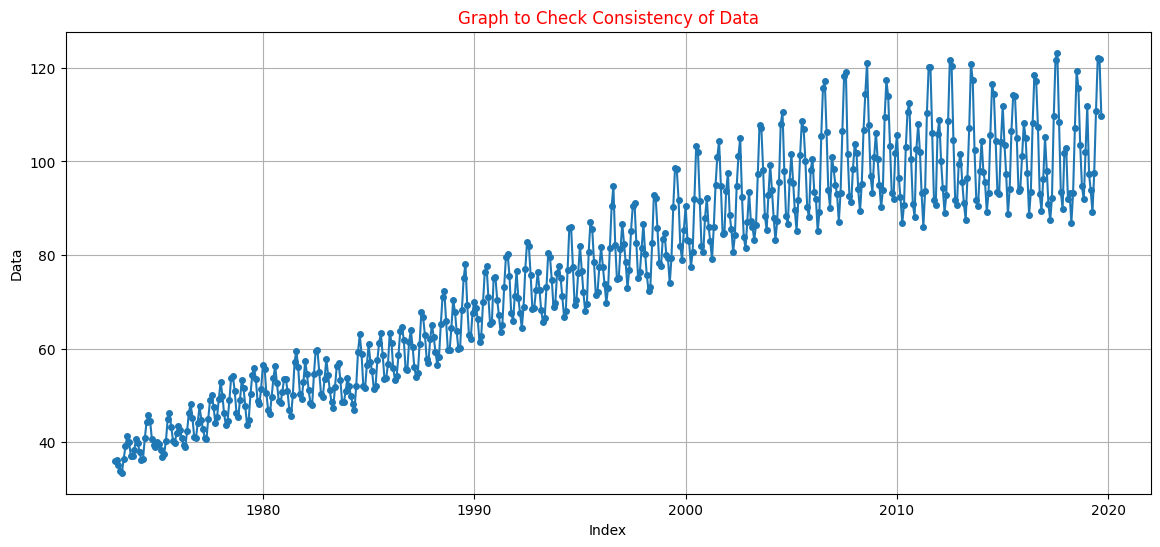

In [12]:
plt.figure(figsize=(14, 6))  # Setting figure size

# Plotting data with markers
plt.plot(Electricity, marker='o', markersize=4, linestyle='-')  # Using markers for each data point and connecting them with lines

# Setting title and color
plt.title("Graph to Check Consistency of Data", color='red')

# Setting labels for axes
plt.xlabel("Index")
plt.ylabel("Data")

# Turning on grid
plt.grid(True)

plt.show()  

### From the above discussion, it's evident that the data exhibits clear trends, maintains stationarity, and the linearity remains unbroken. Therefore, we can conclude that we have consistent data.

#

# Plotting Trend, stationarity,Residual 

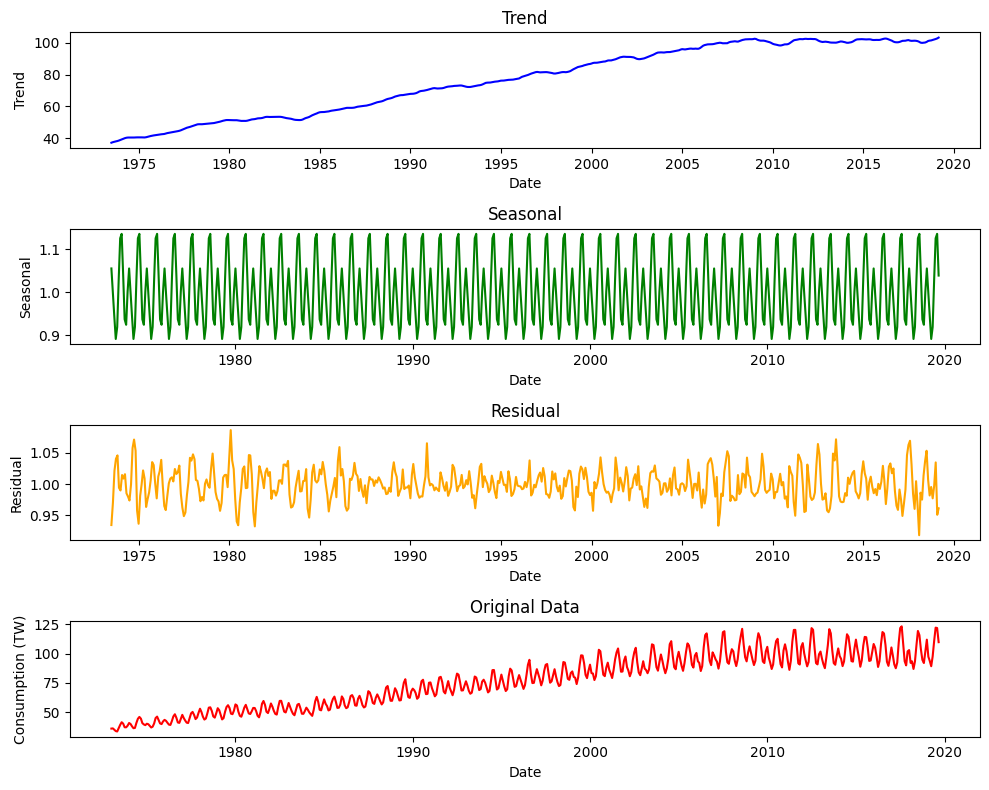

In [13]:
mm = seasonal_decompose(Electricity["Electricty_Consumption_in_TW"], model='multiplicative')


plt.figure(figsize=(10, 8))  
plt.subplots_adjust(hspace=0.4)  # Adjust vertical spacing between subplots

# Plot the seasonal decomposition components
plt.subplot(411)  # Trend subplot
plt.plot(mm.trend, label='Trend', color='blue')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Trend')

plt.subplot(412)  # Seasonal subplot
plt.plot(mm.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Seasonal')

plt.subplot(413)  # Residual subplot
plt.plot(mm.resid, label='Residual', color='orange')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Residual')

plt.subplot(414)  # Original data subplot
plt.plot(Electricity["Electricty_Consumption_in_TW"], label='Original', color='red')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Consumption (TW)')

plt.tight_layout() 
plt.show()

#

# DIVIDING THE DATESET FOR MODEL PREPARATION 

In [70]:
# Specify the percentage of data for training
train_percentage = 0.8  # 80% of the data for training

# Calculate the split index based on the time-based split
split_index = int(len(Electricity) * train_percentage)

# Split the data into training and testing sets
train = Electricity.iloc[:split_index]
test = Electricity.iloc[split_index:]


In [71]:
train.shape

(448, 1)

In [72]:
test.shape

(113, 1)

In [73]:
#Fitting the model with random p,d,q values
model = ARIMA(train, order = (2, 1, 1 ))
model_fit = model.fit()

In [74]:
forecast_steps = len(test)

# Forecast using the calculated number of steps
preds1 = model_fit.forecast(steps=forecast_steps)

In [75]:
mae  = mean_absolute_error(preds1, test)
print(mae)

8.554675062630793


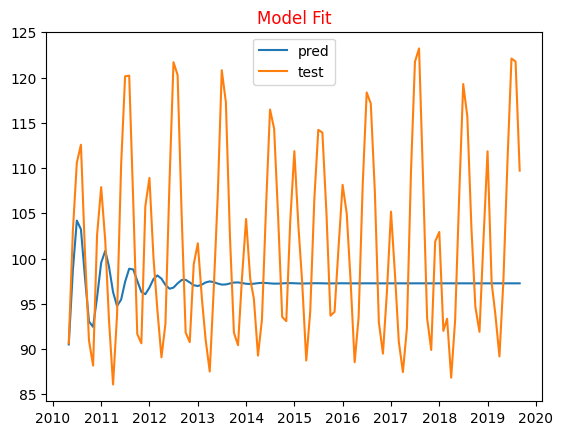

In [76]:
plt.plot(preds1, label = "pred")
plt.plot(preds1.index, test, label = "test")
plt.title("Model Fit",c='r')
plt.legend()
plt.show()

### The plot suggests that the ARIMA model with the specified values of p, d, and q is not fitting the data well

#

### Finding value of p,d,q

In [77]:
from itertools import product

# Define the ranges for p, d, and q
p_range = range(0, 4)
d_range = range(0, 4)
q_range = range(0, 4)

# Create a list of all possible combinations of p, d, and q
orders = list(product(p_range, d_range, q_range))

# Initialize lists to store orders and corresponding mean absolute errors
order_list, mae_list = [], []

# Iterate over each order
for order in orders:
    try:
        # Fit ARIMA model with the current order
        model = ARIMA(train, order=order)
        model_fit = model.fit()

        # Forecast using the trained model
        forecast = model_fit.forecast(steps=len(test))

        # Calculate mean absolute error
        mae = mean_absolute_error(forecast, test)

        # Append order and corresponding mean absolute error to lists
        order_list.append(order)
        mae_list.append(mae)
    except:
        # If the model fitting fails, skip to the next iteration
        continue

# Find the order with the minimum mean absolute error
best_order = order_list[np.argmin(mae_list)]
best_mae = min(mae_list)

print("Best order (p, d, q):", best_order)
print("Corresponding Mean Absolute Error:", best_mae)

Best order (p, d, q): (3, 1, 2)
Corresponding Mean Absolute Error: 5.631146428778587


### Updated the values of p,d,q

In [78]:
model = ARIMA(train, order = (3, 1, 2 ))
model_fit = model.fit()

In [79]:
forecast_steps = len(test)

# Forecast using the calculated number of steps
preds2 = model_fit.forecast(steps=forecast_steps)

In [80]:
mae  = mean_absolute_error(preds2, test)
print(mae)

5.631146428778587


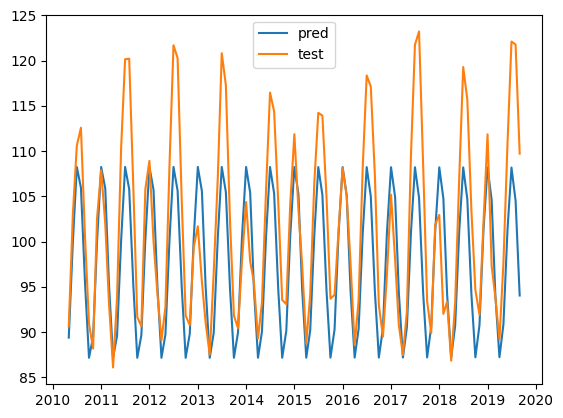

In [81]:
plt.plot(preds2, label = "pred")
plt.plot(preds2.index, test, label = "test")
plt.legend()
plt.show()

### Based on the plot of the training and testing data, it appears that our model adequately captures the underlying patterns in the data.

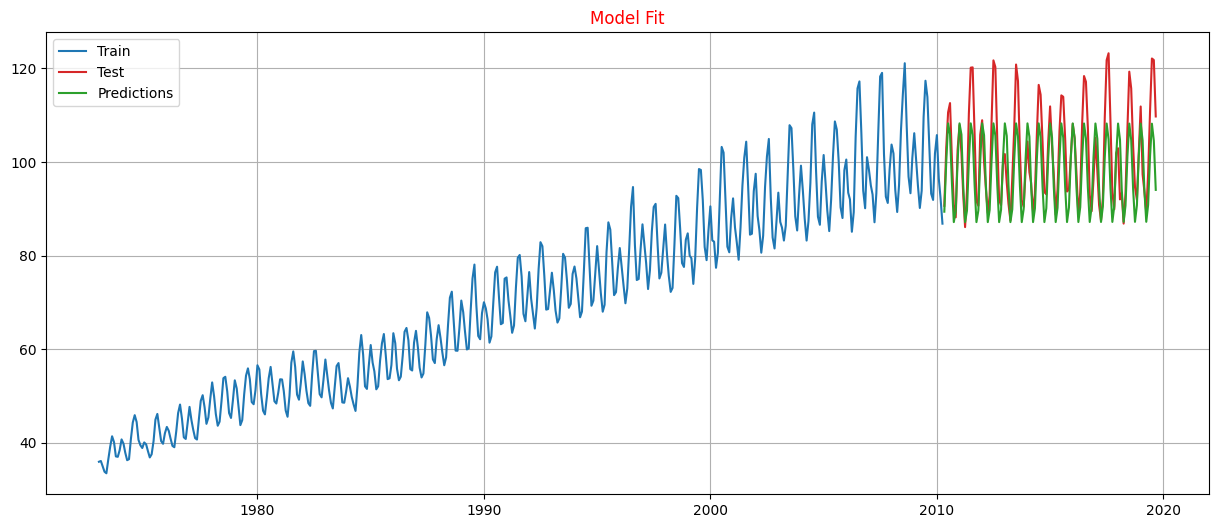

In [82]:
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train, color='#1f77b4', label='Train')

# Plot testing data
plt.plot(test, color='#d62728', label='Test')

# Plot predictions
plt.plot(test.index, preds2, color='#2ca02c', label='Predictions')
plt.legend()
plt.title("Model Fit", color='red')
plt.grid(True)
plt.show()

## SARIMA

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [89]:
order = (3,1, 2)  # p, d, q
seasonal_order  = (3, 1, 2, 12) #P, D, Q, T
model = SARIMAX(train, order=order, seasonal_order= seasonal_order)

model_fit = model.fit(disp=False)
preds3 = model_fit.forecast(steps = len(test))
mean_absolute_error(test, preds3)

3.5885770108525197

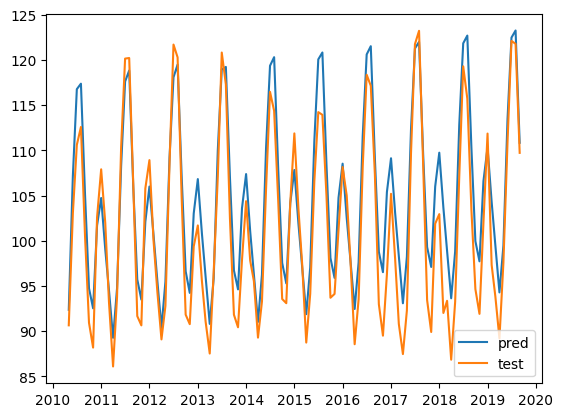

In [90]:
plt.plot(preds3, label = "pred")
plt.plot(preds3.index, test, label = "test")
plt.legend()
plt.show()

## From the above plot of the training and testing data, we can conclude that our model fits the data more effectively

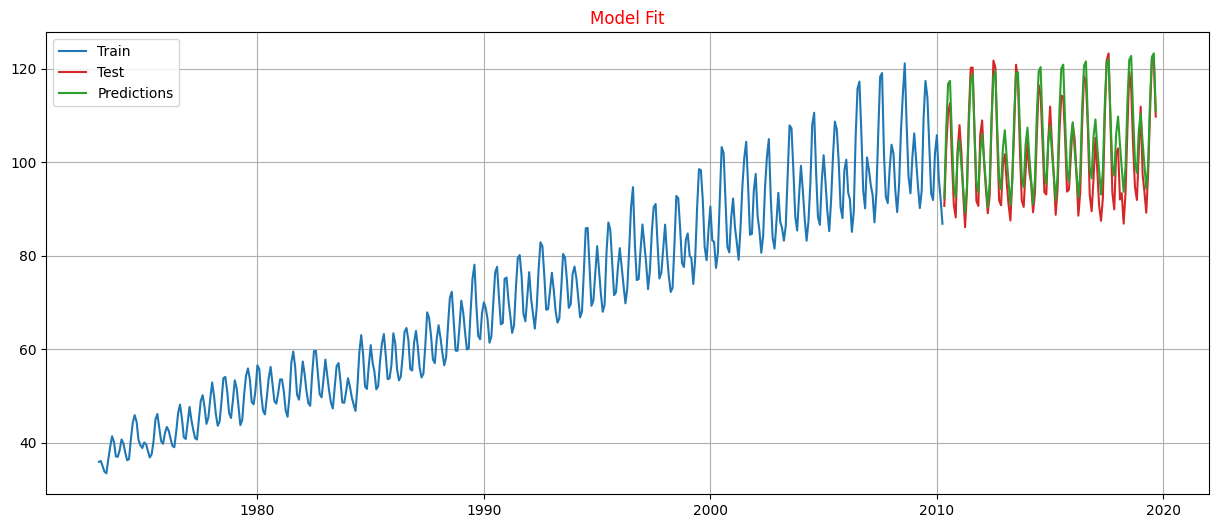

In [91]:
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train, color='#1f77b4', label='Train')

# Plot testing data
plt.plot(test, color='#d62728', label='Test')

# Plot predictions
plt.plot(test.index, preds3, color='#2ca02c', label='Predictions')
plt.legend()
plt.title("Model Fit", color='red')
plt.grid(True)
plt.show()


## Based on the visualizations above, it appears that the SARIMA model fits the data much better, as indicated by the lower MAE scores

#

## Checking other evaluation metrices for SARIMA

In [93]:
mse=mean_squared_error(test,preds3)
mape=mean_absolute_percentage_error(test,preds3)
print("RMSE :: ",np.sqrt(mse))
print("MAPE ::",mape)

RMSE ::  4.17649238396044
MAPE :: 0.036243228956683526


## Based on the evaluation above, it can be concluded that SARIMA outperforms ARIMA. Therefore, SARIMA should be chosen for forecasting


#

## Forecasting data for the next 2 years

In [96]:
preds4 = model_fit.forecast(steps = 24)
preds4

2010-05-01     92.355041
2010-06-01    107.174436
2010-07-01    116.762608
2010-08-01    117.369906
2010-09-01    105.095139
2010-10-01     94.731960
2010-11-01     92.520434
2010-12-01    101.683398
2011-01-01    104.722996
2011-02-01     99.038617
2011-03-01     94.532142
2011-04-01     89.261134
2011-05-01     94.724735
2011-06-01    108.259720
2011-07-01    117.606994
2011-08-01    118.829932
2011-09-01    105.898732
2011-10-01     95.719339
2011-11-01     93.481610
2011-12-01    102.089771
2012-01-01    105.992687
2012-02-01    100.642882
2012-03-01     95.546116
2012-04-01     90.353140
Freq: MS, Name: predicted_mean, dtype: float64